In [1]:
# 数据读取
import pandas as pd
import os
pd.set_option('display.max_columns', None)
data1 = pd.read_csv("data1.csv", encoding="gbk")
data2 = pd.read_csv("data2.csv", encoding="gbk")
data3 = pd.read_csv("data3.csv", encoding="gbk")
data1.columns = ['序号', '校园卡号', '性别', '专业名称', '门禁卡号']
data2.columns = ['流水号', '校园卡号', '校园卡编号', '消费时间', '消费金额', '存储金额', '余额', '消费次数', '消费类型', '消费项目编码', '消费项目序列号', '消费操作编码', '操作编码', '消费地点']
data3.columns = ['序号', '门禁卡号', '进出时间', '进出地点', '是否通过', '描述']
print(data1.head(3))
print(data2.head(3))
print(data3.head(3))

# 数据匹配，匹配上性别数据，分析更直观
data2 = data2.merge(data1[['校园卡号','性别']],on='校园卡号')
data2['校园卡号'] = data2['校园卡号'].apply(lambda x: str(x))+'-'+data2['性别']

   序号    校园卡号 性别    专业名称      门禁卡号
0   1  180001  男  18国际金融  19762330
1   2  180002  男  18国际金融  20521594
2   3  180003  男  18国际金融  20513946
         流水号    校园卡号     校园卡编号             消费时间  消费金额  存储金额     余额  消费次数 消费类型  \
0  117342773  181316  20181316  2019/4/20 20:17   3.0   0.0  186.1   818   消费   
1  117344766  181316  20181316   2019/4/20 8:47   0.5   0.0  199.5   814   消费   
2  117346258  181316  20181316   2019/4/22 7:27   0.5   0.0  183.1   820   消费   

   消费项目编码 消费项目序列号  消费操作编码  操作编码  消费地点  
0      49     NaN     NaN   235  第一食堂  
1      63     NaN     NaN    27  第二食堂  
2      63     NaN     NaN    27  第二食堂  
        序号      门禁卡号           进出时间       进出地点  是否通过    描述
0  1330906  25558880  2019/4/1 0:00  第六教学楼[进门]     1  允许通过
1  1330907  18413143  2019/4/1 0:02  第六教学楼[出门]     1  允许通过
2  1331384  11642752  2019/4/1 0:00    飞凤轩[进门]     1  允许通过


In [2]:
import datetime
'''
函数功能
时间格式调整
'2019/4/20 20:17'=>'2019-04-20 20:17:00'
'''
def st_pt(x):
     return str(datetime.datetime.strptime(x, "%Y/%m/%d %H:%M"))
'''
函数功能
时间切片
5分钟一个切片，且每个时间会切成两个片段
Time2Str('2021-11-16 15:51:39' )
'2021-11-16 15:51:39'  => '2021111615(10);2021111615(11)'
'''
def Time2Str(tsm):
    t0 = datetime.datetime.fromisoformat(tsm)
    t1 = t0+datetime.timedelta(days=0, hours=5/60)
    str1 = t0.strftime("%Y%m%d%H")+'(' +str(round(int(t0.minute/5))).rjust(2,'0')+')'
    str2 = t1.strftime("%Y%m%d%H")+'(' +str(round(int(t1.minute/5))).rjust(2,'0')+')'
    return str1+';'+str2


In [3]:
# 开始数据处理
df = data2
df['消费时间'] = df['消费时间'].apply(st_pt)
df['tsm']     = df['消费时间'].apply(Time2Str)

# 数据分裂，一行变两行
df = df.set_index(["校园卡号", "消费时间",'消费地点'])["tsm"].str.split(";", expand=True)\
    .stack().reset_index(drop=True, level=-1).reset_index().rename(columns={0: "tsm"})
print(df.head(2))

       校园卡号                 消费时间  消费地点             tsm
0  181316-女  2019-04-20 20:17:00  第一食堂  2019042020(03)
1  181316-女  2019-04-20 20:17:00  第一食堂  2019042020(04)


In [4]:
# 数据匹配，加入时间约束和地点约束
df_0 = pd.merge(df,df,on =['tsm','消费地点'],how='inner')
df_0.shape

# 排除 自己和自己匹配的数据
df_1 = df_0[df_0['校园卡号_x']!=df_0['校园卡号_y']]

# 时间作差，大于5分钟的排除
df_1['diff'] = (pd.to_datetime(df_1['消费时间_x'])-pd.to_datetime(df_1['消费时间_y'])).dt.seconds/60
df_1 = df_1[df_1['diff']<=5]

# 提取小时 按共同出现的小时计数
df_1['date'] = df_1['tsm'].apply(lambda x :x[0:10])

#统计两两关联的次数，这里比较简单，不按天，也不计算相似度了
df_2 = df_1.groupby(['校园卡号_x','校园卡号_y']).agg({'date': pd.Series.nunique}).reset_index()

# 降序排列
df_2 = df_2.sort_values(by='date',ascending=False)

/var/folders/t1/h_38vh5s1tsb_8vd1_0yvnl40000gn/T/ipykernel_39599/2466092042.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['diff'] = (pd.to_datetime(df_1['消费时间_x'])-pd.to_datetime(df_1['消费时间_y'])).dt.seconds/60


In [5]:
# 给关系加阈值，大于20次的算是比较强的关联了
df_3 = df_2[df_2['date']>=20]

df_3.shape

(1924, 3)

In [6]:
# 二、LPA分群
# 这里我们直接调用networkx库里的asyn_lpa_communities算法，对上面的关系数据进行分群，每个学生都会分布到一个独立的群体里面。为了得到不同程度的关系，我们可以调节关联次数这个阈值。大家可以多测试几个看看

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.community import asyn_lpa_communities as lpa


# 数据格式转换
tuples = [tuple(x) for x in df_3[['校园卡号_x','校园卡号_y']].values]
G = nx.DiGraph()
G.add_edges_from(tuples)

# LPA本身不稳定，因此，社群存在小范围波动
com = list(lpa(G))
print('社区数量',len(com))


社区数量 446


In [8]:
# # 打印分群数据 仅展示部分数据
# for i in com:
#     print(i)
# {'181559-男', '181568-男', '181556-男', '181564-男'}
# {'181013-女', '181042-女', '180624-男'}

In [9]:
# 渣女组合
result = data2[(data2['校园卡号']=='181623-男') | (data2['校园卡号']=='183847-女') | \
      (data2['校园卡号']=='181597-男')]
# 情侣组合
result = data2[(data2['校园卡号']=='181774-男') | (data2['校园卡号']=='183898-女')]
result = result.sort_values(by='消费时间')

# 用户 -时间-地点关系数据
result = df_1[((df_1['校园卡号_x']=='181774-男') & (df_1['校园卡号_y']=='183898-女')) | \
              ((df_1['校园卡号_y']=='181774-男') & (df_1['校园卡号_x']=='183898-女'))]

# 数据整理保存备用
result.to_csv('resualt.csv',index=False,header=True)

In [10]:
result

,校园卡号_x,消费时间_x,消费地点,tsm,校园卡号_y,消费时间_y,diff,date
303517,183898-女,2019-04-11 11:54:00,第四食堂,2019041111(11),181774-男,2019-04-11 11:54:00,0.0,2019041111
319011,181774-男,2019-04-11 11:54:00,第四食堂,2019041111(11),183898-女,2019-04-11 11:54:00,0.0,2019041111
2675117,183898-女,2019-04-10 11:54:00,第四食堂,2019041011(11),181774-男,2019-04-10 11:54:00,0.0,2019041011
2685265,181774-男,2019-04-10 11:54:00,第四食堂,2019041011(11),183898-女,2019-04-10 11:54:00,0.0,2019041011
2988985,183898-女,2019-04-12 11:20:00,第三食堂,2019041211(04),181774-男,2019-04-12 11:20:00,0.0,2019041211
...,...,...,...,...,...,...,...,...
38052409,181774-男,2019-04-15 11:39:00,第四食堂,2019041511(07),183898-女,2019-04-15 11:39:00,0.0,2019041511
38053836,183898-女,2019-04-15 11:39:00,第四食堂,2019041511(08),181774-男,2019-04-15 11:39:00,0.0,2019041511
38055456,181774-男,2019-04-15 11:39:00,第四食堂,2019041511(08),183898-女,2019-04-15 11:39:00,0.0,2019041511
38057706,183898-女,2019-04-18 17:23:00,第四食堂,2019041817(05),181774-男,2019-04-18 17:20:00,3.0,2019041817


IndexError: list index out of range

/Users/zhusx/opt/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from current font.
  func(*args, **kwargs)
/Users/zhusx/opt/anaconda3/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Glyph 30007 (\N{CJK UNIFIED IDEOGRAPH-7537}) missing from current font.
  func(*args, **kwargs)
/Users/zhusx/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22899 (\N{CJK UNIFIED IDEOGRAPH-5973}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/zhusx/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30007 (\N{CJK UNIFIED IDEOGRAPH-7537}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


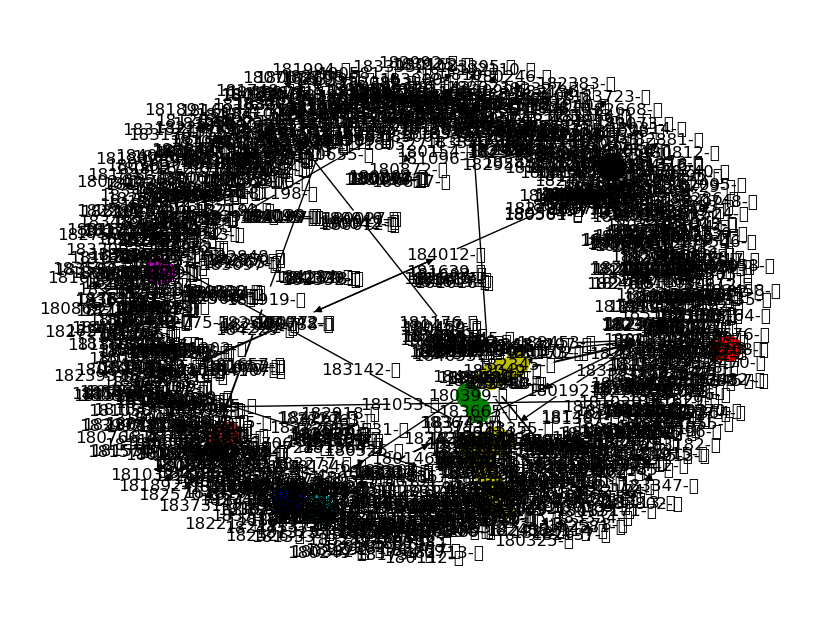

In [11]:
# 下面是画图 
pos = nx.spring_layout(G) # 节点的布局为spring型
NodeId    = list(G.nodes())
node_size = [G.degree(i)**1.2*90 for i in NodeId] # 节点大小

plt.figure(figsize = (8,6)) # 图片大小
nx.draw(G,pos, with_labels=True, 
        node_size =node_size, 
        node_color='w', 
        node_shape = '.'
        )
'''
node_size表示节点大小
node_color表示节点颜色
with_labels=True表示节点是否带标签
'''
color_list = ['pink','orange','r','g','b','y','m','gray','black','c','brown']

for i in range(len(com)):
    nx.draw_networkx_nodes(G, pos, nodelist = com[i], 
                           node_color=color_list[i+2],  
                           label=True)
plt.show()